# Splitting track into mini-sectors

In [28]:
import sys
import fastf1
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

sys.path.append("../..")
from utils import rotate
from common import Config

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [2]:
fastf1.Cache.enable_cache(Config.FASTF1_CACHE_DIR)
fastf1.set_log_level('WARNING')

## Load Session Data

In [3]:
session = fastf1.get_session(2024, 'Saudi Arabia', 'R')
weekend = session.event
session.load()
circuit_info = session.get_circuit_info()
weather_df = session.laps.get_weather_data()

logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [4]:
# Generic track info
track_angle_rad = circuit_info.rotation * np.pi / 180  # Converting to radians
fastest_lap = session.laps.pick_fastest().get_telemetry()
track_distance = fastest_lap['Distance'].max() / fastest_lap['RelativeDistance'].max()

# Getting track layout (taken from any lap)
lap = session.laps.pick_fastest()
track_df = lap.get_pos_data()[['X', 'Y', 'Z']]
track_df[['X_rotated', 'Y_rotated']] = rotate(track_df[['X', 'Y']].to_numpy(), angle=track_angle_rad)

# Getting circuit corners
corners_df = circuit_info.corners.copy()
corners_df[['X_rotated', 'Y_rotated']] = rotate(corners_df[['X', 'Y']].to_numpy(), angle=track_angle_rad)
corners_df['Distance_CornerStart'] = corners_df['Distance'] - Config.CORNER_START_OFFSET_M
corners_df['Distance_CornerEnd'] = corners_df['Distance'] + Config.CORNER_END_OFFSET_M

# Appending last and first corners to create a closed loop
corners_df = pd.concat([
    corners_df.iloc[[-1], :].assign(keep=False, Distance=lambda x: x['Distance'] - track_distance, Distance_CornerStart=lambda x: x['Distance_CornerStart'] - track_distance, Distance_CornerEnd=lambda x: x['Distance_CornerEnd'] - track_distance),
    corners_df.assign(keep=True),
    corners_df.iloc[[0], :].assign(keep=False, Distance=lambda x: x['Distance'] + track_distance, Distance_CornerStart=lambda x: x['Distance_CornerStart'] + track_distance, Distance_CornerEnd=lambda x: x['Distance_CornerEnd'] + track_distance),
], axis=0)
corners_df['__Distance_NextCorner__'] = corners_df['Distance'].shift(-1)
corners_df['__Distance_NextCornerStart__'] = corners_df['Distance_CornerStart'].shift(-1)
corners_df['__Distance_PrevCorner__'] = corners_df['Distance'].shift(1)
corners_df['__Distance_PrevCornerEnd__'] = corners_df['Distance_CornerEnd'].shift(1)
corners_df = corners_df.query("keep == True").reset_index(drop=True).drop(columns=['keep'])
corners_df['__Distance_Corner_Corrected__'] = np.where(
    (corners_df['Distance_CornerStart'] < corners_df['__Distance_PrevCornerEnd__']) | (corners_df['Distance_CornerEnd'] > corners_df['__Distance_NextCornerStart__']),
    True, False
)
corners_df['Distance_CornerStart'] = np.where(
    corners_df['Distance_CornerStart'] < corners_df['__Distance_PrevCornerEnd__'],
    (corners_df['Distance'] + corners_df['__Distance_PrevCorner__']) / 2,
    corners_df['Distance_CornerStart']
)
corners_df['Distance_CornerEnd'] = np.where(
    corners_df['Distance_CornerEnd'] > corners_df['__Distance_NextCornerStart__'],
    (corners_df['Distance'] + corners_df['__Distance_NextCorner__']) / 2,
    corners_df['Distance_CornerEnd']
)
corners_df['LapCompletion'] = corners_df['Distance'] / track_distance
corners_df['LapCompletion_CornerStart'] = corners_df['Distance_CornerStart'] / track_distance
corners_df['LapCompletion_CornerEnd'] = corners_df['Distance_CornerEnd'] / track_distance
corners_df = corners_df.drop(columns=['__Distance_NextCorner__', '__Distance_NextCornerStart__', '__Distance_PrevCorner__', '__Distance_PrevCornerEnd__', '__Distance_Corner_Corrected__'])

# Converting the corner distances into a mini-sector
minisectors_df = [pd.DataFrame({
    'MiniSectorId': 1,
    'LapCompletion_Start': -999,
    'isCorner': False,
    'CornerNumber': '',
    'CornerLetter': '',
}, index=[0])]
for idx, corner in corners_df.iterrows():
    minisectors_df.append(pd.DataFrame({
        'MiniSectorId': idx + 2,
        'LapCompletion_Start': corner['LapCompletion_CornerStart'],
        'isCorner': True,
        'CornerNumber': corner['Number'],
        'CornerLetter': corner['Letter'],
    }, index=[0]))
    minisectors_df.append(pd.DataFrame({
        'MiniSectorId': idx + 3,
        'LapCompletion_Start': corner['LapCompletion_CornerEnd'],
        'isCorner': False,
        'CornerNumber': '',
        'CornerLetter': '',
    }, index=[0]))
minisectors_df = pd.concat(minisectors_df, axis=0).reset_index(drop=True)
minisectors_df = minisectors_df.sort_values(['LapCompletion_Start', 'isCorner'], ascending=[True, False])\
    .drop_duplicates(subset=['LapCompletion_Start'], keep='first').reset_index(drop=True)
minisectors_df['MiniSectorId'] = np.arange(1, len(minisectors_df) + 1)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [5]:
corners_df.head(3)

,X,Y,Number,Letter,Angle,Distance,X_rotated,Y_rotated,Distance_CornerStart,Distance_CornerEnd,LapCompletion,LapCompletion_CornerStart,LapCompletion_CornerEnd
0,-2908.523056,4757.490498,1,,69.136629,477.981422,-3912.537287,-3973.068611,377.981422,505.977360,0.078262,0.061889,0.082846
1,-3463.171720,4834.551790,2,,40.811417,533.973298,-3853.127873,-4529.884653,505.977360,558.973298,0.087430,0.082846,0.091523
2,-3333.324770,6205.801601,3,,-3.557132,686.951530,-5215.058525,-4735.630065,586.951530,711.951530,0.112478,0.096104,0.116571


In [6]:
minisectors_df.head(5)

,MiniSectorId,LapCompletion_Start,isCorner,CornerNumber,CornerLetter
0,1,-999.000000,False,,
1,2,0.061889,True,1,
2,3,0.082846,True,2,
3,4,0.091523,False,,
4,5,0.096104,True,3,


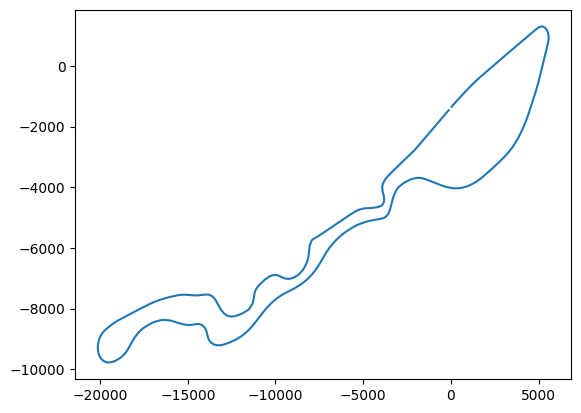

In [7]:
plt.plot(track_df['X_rotated'], track_df['Y_rotated'])

## Sectioning each driver's data based on minisectors

In [8]:
driver = 'VER'

driver_laps = session.laps.pick_driver(driver)
driver_telemetry_df = driver_laps.get_telemetry().query("Source == 'car'")
driver_telemetry_df['LapNumber'] = pd.cut(
    driver_telemetry_df['Date'],
    bins=driver_laps['LapStartDate'].tolist() + [driver_laps['LapStartDate'].max() + timedelta(days=1)],
    labels=driver_laps['LapNumber'].to_list(),
    include_lowest=True,
)
driver_telemetry_df['LapCompletion'] = driver_telemetry_df['Distance'] % track_distance / track_distance
driver_telemetry_df['MiniSectorId'] = pd.cut(
    driver_telemetry_df['LapCompletion'],
    bins=minisectors_df['LapCompletion_Start'].to_list() + [1],
    labels=minisectors_df['MiniSectorId'].to_list(),
    include_lowest=True,
)
driver_telemetry_df = driver_telemetry_df.merge(
    minisectors_df[['MiniSectorId', 'isCorner', 'CornerNumber', 'CornerLetter']], on='MiniSectorId', how='left'
)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [9]:
driver_telemetry_df.groupby(['MiniSectorId', 'isCorner', 'CornerNumber', 'CornerLetter']).agg({'Speed': ['min', 'mean', 'max']}).round(0)\
    .style.bar(color='lightblue').format('{:.0f}')

## Visualise Minisectors

In [10]:
# First, calculate the average speed across each minisector
def agg_minisector(df):
    return pd.DataFrame({
        'Speed_min': df['Speed'].min(),
        'Speed_mean': df['Speed'].mean(),
        'Speed_max': df['Speed'].max(),
        'Gear_min': df['nGear'].min(),
        'Gear_max': df['nGear'].max(),
    }, index=[0])

minisector_stats_df = driver_telemetry_df.groupby(['MiniSectorId', 'isCorner', 'CornerNumber', 'CornerLetter'])\
    .apply(lambda x: agg_minisector(x)).reset_index().drop(columns=['level_4'])

In [12]:
# Creating an artificial telemetry data with the average speed across each minisector
minisector_lap_df = driver_telemetry_df.query("LapNumber == 1")[['MiniSectorId', 'X', 'Y', 'Z', 'Distance', 'LapCompletion']]\
    .merge(minisector_stats_df, on='MiniSectorId', how='left')
minisector_lap_df[['X_rotated', 'Y_rotated']] = rotate(minisector_lap_df[['X', 'Y']].to_numpy(), angle=track_angle_rad)
minisector_lap_df = pd.concat([
    minisector_lap_df,
    minisector_lap_df.iloc[[0], :]
], axis=0).reset_index(drop=True)

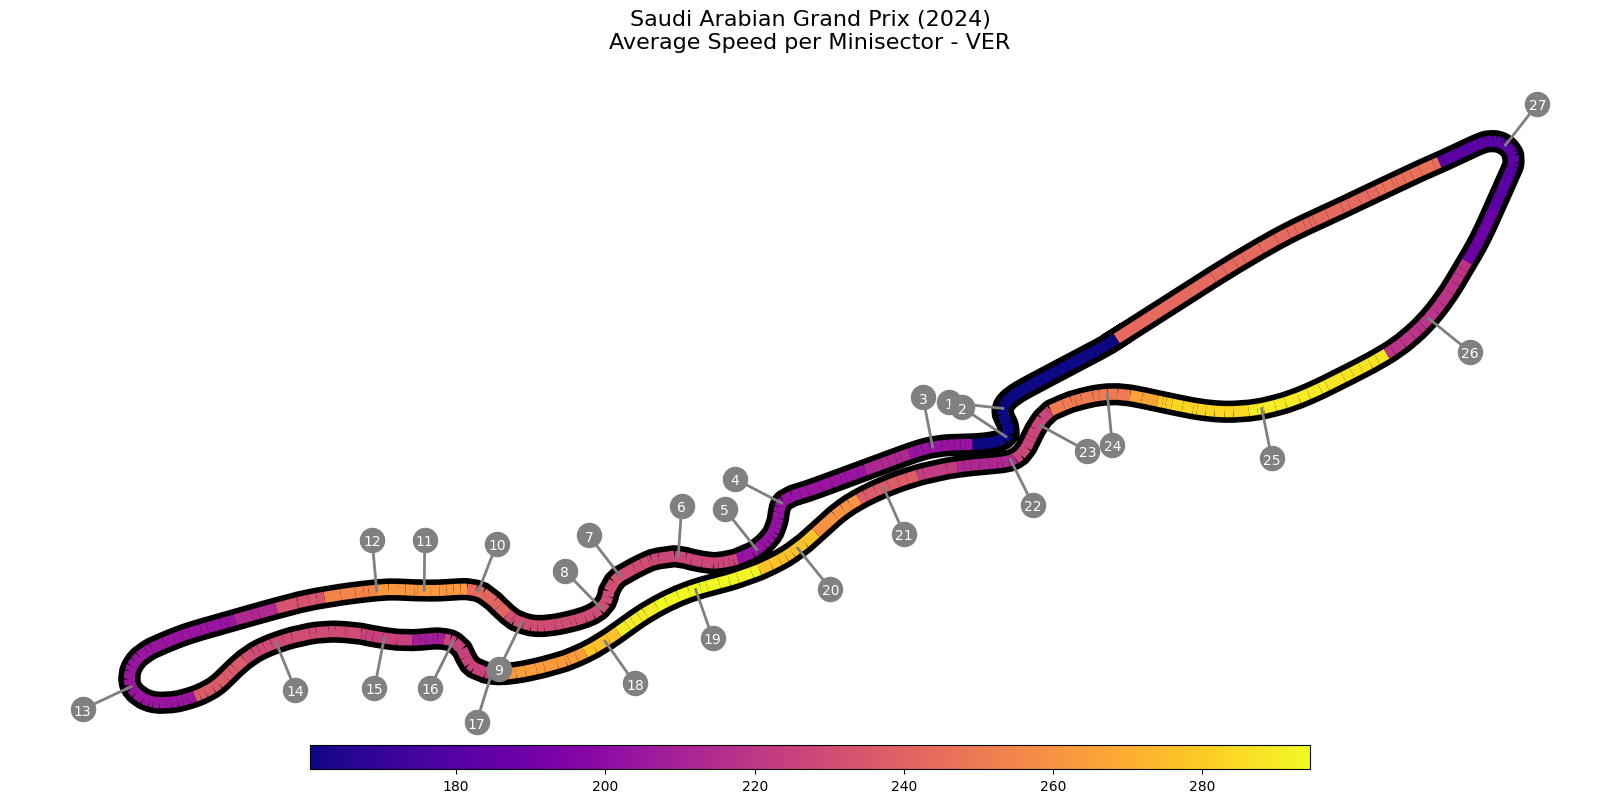

In [74]:
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle(f"{weekend.EventName} ({weekend.year})\nAverage Speed per Minisector - {driver}", fontsize=16)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05)
ax.axis('off')

ax.plot(minisector_lap_df['X_rotated'], minisector_lap_df['Y_rotated'], color='black', linewidth=16, zorder=0)

# Adding the average speed across each minisector
cmap = mpl.cm.plasma
points = np.array([minisector_lap_df['X_rotated'], minisector_lap_df['Y_rotated']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(minisector_lap_df['Speed_mean'].min(), minisector_lap_df['Speed_mean'].max())
lc = LineCollection(
    # [minisector_lap_df[['X_rotated', 'Y_rotated']].to_numpy()],
    segments,
    cmap=cmap, norm=norm, linestyle='-', linewidth=8, zorder=1
)
lc.set_array(minisector_lap_df['Speed_mean'])
line = ax.add_collection(lc)  # Merge all line segments together

# Adding colorbar
cb_axes = fig.add_axes([0.25, 0.03, 0.5, 0.03])
normlegend = mpl.colors.Normalize(vmin=minisector_lap_df['Speed_mean'].min(), vmax=minisector_lap_df['Speed_mean'].max())
legend = mpl.colorbar.ColorbarBase(cb_axes, cmap=cmap, norm=normlegend, orientation='horizontal')

# Adding corner labels
offset_vector = [1000, 0]  # offset length is chosen arbitrarily to 'look good'
for _, corner in corners_df.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    offset_angle = corner['Angle'] * np.pi / 180
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)
    text_x, text_y = corner['X'] + offset_x, corner['Y'] + offset_y
    text_x, text_y = rotate([text_x, text_y], angle=track_angle_rad)
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle_rad)
    ax.scatter(text_x, text_y, color='grey', s=300, zorder=2)
    ax.plot([track_x, text_x], [track_y, text_y], color='grey', linewidth=2, zorder=2)
    ax.text(text_x, text_y, txt, fontsize=10, color='white', ha='center', va='center_baseline', zorder=2)